# Bootstrapping: Emittance uncertainty calculation

In [1]:
import statistics
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from random import seed
from time import time

#### First, reading the raw data and displaying them in a dataframe.

In [2]:
I_meas, sigm = np.loadtxt('2_medida_emittance_planeX_E_147.8_MULTIBUNCH.txt', skiprows=2, unpack=True)
current, err_current, sigma,err_sigma  = [],[],[],[]
for i in range(0, len(I_meas), 4):
    current.append(np.mean(I_meas[i:i+4]))
    err_current.append(np.std(I_meas[i:i+4]))
    sigma.append(np.mean(sigm[i:i+4]))
    err_sigma.append(np.std(sigm[i:i+4]))
Data = pd.DataFrame({' Current [A]':current,
                     '$\pm$ uncert. [A]': err_current,
                     'Beam size [mm]':np.array(sigma)*1000,
                     '$\pm$ uncert. [mm]': np.array(err_sigma)*1000})
Data

,Current [A],$\pm$ uncert. [A],Beam size [mm],$\pm$ uncert. [mm]
0,0.599469,0.000463,0.841789,0.000379
1,0.680176,0.000608,0.810870,0.000358
2,0.759980,0.000768,0.781524,0.000427
3,0.839422,0.000189,0.759312,0.000159
4,0.919748,0.000872,0.746339,0.000348
5,0.999935,0.000570,0.738818,0.000750
6,1.079443,0.000543,0.742549,0.000190
7,1.160010,0.000788,0.753461,0.007116
8,1.240282,0.000468,0.763682,0.000262
9,1.319938,0.000763,0.797372,0.000028


#### Setting the experimental set-up data

In [3]:
I2K1 = [-0.0089, 2.1891, 0.0493] # Fitting values to transform from current to quadrupole strength
DIST = 2.8775                    # Space (drift) between the quadrupole and the camera
QUAD_L = 0.112                   # Quadrupole length
light_speed = 299792458          # in m/s
electron_rest_en = 0.5109989461  # in MeV
energy = 147.8                   # beam energy in MeV

### Loading the necessary functions

In [4]:
def _get_K1_from_I(energy, I_meas):
    '''
    Function to calculate the quadrupole strength using the quadrupole current
    '''
    kin_en = np.sqrt(energy*energy - electron_rest_en*electron_rest_en)
    return np.polyval(I2K1, I_meas)*light_speed/kin_en/1e6

In [5]:
def _twiss(s_11 , s_12, s_22, energy):
    '''
    Funtion to calculate the normalize emittance and the 
    twiss parameters using the components of the emittance matrix
    '''
    emit = np.sqrt(abs(s_11 * s_22 - s_12 * s_12))
    beta = s_11 / emit
    alpha = -s_12 / emit
    gamma = s_22 / emit
    nemit = emit * energy / electron_rest_en * 1e6  # in mm.mrad
    return nemit, beta, alpha, gamma

In [6]:
def _trans_matrix_method(energy, I_meas, sigma, pl='x'):
    '''
    Function to calculate the beam emittance using transfer matrices
    '''
    K1 = _get_K1_from_I(energy,I_meas)
    Rx, Ry = _get_resp_mat(K1, energy)
    R = Rx if pl == 'x' else Ry
    pseudo_inv = np.dot(np.linalg.inv(np.dot(np.transpose(R) , R)) , np.transpose(R))
    [s_11, s_12, s_22] = pseudo_inv @ (sigma*sigma)
    #s_11, s_12, s_22 = np.linalg.lstsq(R, sigma * sigma, rcond=None)[0]
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [7]:
def quadratic_fit(x, y, weighted = False, ws = [], correlation = False):
    '''
    Function to calculate the quadratic fitting parameters given 2 arrays
    '''
    x = np.array(x)
    y = np.array(y)
    x2 = x*x
    x_m = np.mean(x)
    y_m = np.mean(y)
    x2_m = np.mean(x2)
    
    if weighted == True:
        c, b, a = np.polyfit(x, y, 2, w = ws)
        y_m = np.sum(ws*y)/np.sum(ws)
    else:
        sxx, sxy, sxx2, sx2x2, sx2y = 0, 0, 0, 0, 0

        for i in range(len(x)): 
            sxx += (x[i] - x_m)**2 
            sxy += (x[i] - x_m)*(y[i] - y_m) 
            sxx2 += (x[i] - x_m)*(x2[i] - x2_m) 
            sx2x2 += (x2[i] - x2_m)**2 
            sx2y += (x2[i] - x2_m)*(y[i] - y_m)  

        b = (sxy*sx2x2-sx2y*sxx2)/(sxx*sx2x2-sxx2*sxx2)
        c = (sx2y*sxx-sxy*sxx2)/(sxx*sx2x2-sxx2*sxx2)
        a = y_m - b*x_m - c*x2_m
    
    n, d = 0, 0
    for i in range(len(x)):
        n += (y[i] - (a + b*x[i]+c*x[i]*x[i]))**2
        d += (y[i]- y_m)**2
    r = np.sqrt(1-n/d)
    
    if correlation == True:
        return  a, b, c, r
    else: 
        return  a, b, c     

In [8]:
def _thin_lens_method(energy, I_meas, sigma, pl='x', weighted = 'False', error=[]):
    '''
    Function to calculate the beam emittance using the thin lens approximation 
    method with quadratic fitting parameters
    '''
    I_meas2 = I_meas if pl == 'x' else -I_meas
    K1 = _get_K1_from_I(energy,I_meas2)
    
    if weighted == 'True':
        c, b, a = quadratic_fit(K1, sigma*sigma, weighted=True, ws = 1/(2*np.array(error))**2)
    else:
        c, b, a = quadratic_fit(K1, sigma*sigma)
    
    d = DIST + QUAD_L/2
    l = QUAD_L
    s_11 = a/(d*l)**2
    s_12 = (-b-2*d*l*s_11)/(2*l*d*d)
    s_22 = (c-s_11-2*d*s_12)/d**2
    nemit, beta, alpha, gamma = _twiss(s_11, s_12, s_22, energy)
    return nemit, beta, alpha, gamma

In [9]:
def gettransmat(type, L, gamma, K1=None, B=None):
    '''
    Function to calculate a transfer matrix
    '''
    R = np.eye(6)

    if type.lower().startswith('qu') and K1 is not None and K1 == 0:
        type = 'drift'
    if type.lower().startswith('dr'):
        R = np.array([
            [1, L, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, L, 0, 0],
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, L/gamma**2],
            [0, 0, 0, 0, 0, 1],
            ])
    elif type.lower().startswith('qu') and K1 is not None:
        kq = np.sqrt(abs(K1))
        c = np.cos(kq*L)
        s = np.sin(kq*L)
        ch = np.cosh(kq*L)
        sh = np.sinh(kq*L)
        if K1 > 0:
            x11, x12, x21 = c,  1/kq*s, -kq*s
            y11, y12, y21 = ch, 1/kq*sh, kq*sh
        else:
            x11, x12, x21 = ch, 1/kq*sh, kq*sh
            y11, y12, y21 = c,  1/kq*s, -kq*s
        R = np.array([
            [x11, x12, 0,   0,   0, 0],
            [x21, x11, 0,   0,   0, 0],
            [0,   0,   y11, y12, 0, 0],
            [0,   0,   y21, y11, 0, 0],
            [0,   0,   0,   0,   1, L/gamma**2],
            [0,   0,   0,   0,   0, 1],
            ])
    elif type.lower().startswith('sol') and B is not None:
        K = -light_speed*B/2.0/electron_rest_en/gamma/1e6
        C = np.cos(K*L)
        S = np.sin(K*L)
        SC = C*S
        C2 = C**2
        S2 = S**2
        R = np.array([
            [C2,    SC/K,  SC,    S2/K, 0., 0.],
            [-K*SC, C2,    -K*S2, SC,   0., 0.],
            [-SC,   -S2/K, C2,    SC/K, 0., 0.],
            [K*S2,  -SC,   -K*SC, C2,   0., 0.],
            [0.,    0.,    0.,    0.,   1., L/(gamma**2)],
            [0.,    0.,    0.,    0.,   0., 1.]
            ])
    return R

In [10]:
def _get_resp_mat(K1, energy):
    '''
    Function to calculate the total transfer matrix of the experiment
    '''
    gamma = energy/electron_rest_en
    R = np.zeros((len(K1), 6, 6))
    Rd = gettransmat('drift', L=DIST, gamma=gamma)
    for i, k1 in enumerate(K1):
        Rq = gettransmat('quad', L = QUAD_L, gamma=gamma, K1=k1)
        R[i] = np.dot(Rd, Rq)
    R11 = R[:, 0, 0].reshape(-1, 1)
    R12 = R[:, 0, 1].reshape(-1, 1)
    R33 = R[:, 2, 2].reshape(-1, 1)
    R34 = R[:, 2, 3].reshape(-1, 1)
    Rx = np.column_stack((R11*R11, 2*R11*R12, R12*R12))
    Ry = np.column_stack((R33*R33, 2*R33*R34, R34*R34))
    return Rx, Ry

In [11]:
def plot_histo(data_tm, data_tl, data_tlw, xaxis= r'$\epsilon$ [mmm.rad]', ax=None, **plt_kwargs):
    '''
    Function to plot two histograms with  their main properties
    '''

    ax.hist(data_tm, bins=50, range=[min(data_tm), max(data_tm)], fc='none',
            histtype='step', color='black', label='TM, $\mu$: '+str(round(data_tm.mean(),3))+', $\sigma$: '+
             str(round( np.std(data_tm),3)), linewidth=.8)
    
    ax.hist(data_tl, bins=50, range=[min(data_tl), max(data_tl)],  fc='none',
            histtype='step', color = 'maroon', label='TL, $\mu$: '+str(round(data_tl.mean(),3))+', $\sigma$: '+
             str(round( np.std(data_tl),3)), linewidth=.8)

    ax.hist(data_tlw, bins=50, range=[min(data_tlw), max(data_tlw)], fc='none',
            histtype='step', color = 'steelblue', label='TLW, $\mu$: '+str(round(data_tlw.mean(),3))+', $\sigma$: '+
             str(round( np.std(data_tlw),3)), linewidth=.8)
    
    ax.legend(loc='lower right')
    ax.set_xlabel(xaxis, x=1, ha='right',size= 10 )
    ax.set_ylabel('amplitude', y=1, ha='right',size= 10)
    return ax

In [12]:
def emit_montec(energy, sigma, err_s, I, err_I, plane, M, plot = True, times = False):
    '''
    Function to resample the raw data and calculate the beam emittance uncertainty
    '''
    nemit_t,beta_t, alpha_t,gamma_t =np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    nemit_tl, beta_tl, alpha_tl, gamma_tl = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    nemit_tlw, beta_tlw, alpha_tlw, gamma_tlw = np.zeros(M), np.zeros(M), np.zeros(M), np.zeros(M)
    time_t, time_tl, time_tlw = 0, 0, 0
    for m in range(M):
        sigma_mont_s = []
        I_mont_s = []
        for i in range(len(sigma)):
            sigma_mont_s.append(sigma[i] + err_s[i]*np.random.randn())
            I_mont_s.append(I[i] + err_I[i]*np.random.randn())
        sigma_mont_s = np.array(sigma_mont_s)
        t1 = time()
        nemit_t[m], beta_t[m],alpha_t[m],gamma_t[m] =  _trans_matrix_method(energy, I_mont_s, sigma_mont_s, pl=plane)
        t2 = time()
        nemit_tl[m], beta_tl[m], alpha_tl[m], gamma_tl[m] =_thin_lens_method(energy, I_mont_s, sigma_mont_s, pl=plane)
        t3 = time()
        nemit_tlw[m], beta_tlw[m], alpha_tlw[m], gamma_tlw[m] =_thin_lens_method(energy, I_mont_s, sigma_mont_s, pl=plane, weighted = 'True', error=err_s)
        t4 = time()
        time_t += t2 - t1
        time_tl += t3 - t2
        time_tlw += t4 - t3
        
    if plot == True:
        sigma = np.array(sigma)*1000 # in mm
        error = np.array(err_s)*1000 # in mm
        K1 = _get_K1_from_I(energy, I) # in mm 
        err_K1 = _get_K1_from_I(energy, err_I)
        a1, b1, c1, r1 = quadratic_fit(K1,sigma*sigma, correlation = True)
        a2, b2, c2, r2 = quadratic_fit(K1, sigma*sigma, weighted= True, ws = 1/(2*np.array(error))**2, correlation = True)
        K = np.linspace(min(K1), max(K1), 100)
        
        # Confidence interval
        resid = sigma*sigma - (a2+b2*K1+c2*K1**2)
        s_err = np.sqrt(np.sum(resid**2)/(len(resid) - 1))    
        t = stats.t.ppf(0.975, len(K1)-1) # t = 0.975 for 95 % of confidence
        ci = t * s_err * np.sqrt(1/len(K1) + (K1 - np.mean(K1))**2/np.sum((K1-np.mean(K1))**2))    
        #
        fig = plt.figure(figsize=(10,15))
        gs = GridSpec(3,2) # 3 rows, 2 columns
        ax1 = fig.add_subplot(gs[0,0:2])
        ax2 = fig.add_subplot(gs[1,0])
        ax3 = fig.add_subplot(gs[1,1])
        ax4 = fig.add_subplot(gs[2,0])
        ax5 = fig.add_subplot(gs[2,1])
        
        ax1.plot(K , a1+b1*K+c1*K**2, '--', label = 'Unweighted fitting, $\sigma^2$ = '+str(round(c1, 3))+ 'k$^2$ '+str(round(b1, 3))+'k + '+str(round(a1, 3))+', R$^2$ = '+str(round(r1*r1,4)))
        ax1.plot(K , a2+b2*K+c2*K**2, '--', label = 'Weighted fitting, $\sigma^2$ = ' +str(round(c2, 3))+ 'k$^2$ '+str(round(b2, 3))+'k + '+str(round(a2, 3))+', R$^2$ = '+str(round(r2*r2,4)))
        ax1.errorbar( K1,sigma*sigma, xerr = err_K1,  yerr= 2*error, fmt = 'ro', markersize = 3, ecolor = 'red', capsize = 3,  linewidth = 0.5, color = 'darkblue', label = "Experimental Data")
        ax1.fill_between(K1, (a2+b2*K1+c2*K1**2) + ci, (a2+b2*K1+c2*K1**2) - ci, color=[1, 0, 0, 0.15], label = "Confidence interval (95%)") 
        ax1.set_xlabel('K(I) [1/m$^2$]')
        ax1.set_ylabel('Beam size$^2$ [mm$^2$]')
        ax1.legend()
    
        plot_histo(nemit_t, nemit_tl, nemit_tlw, xaxis = r'$\epsilon$ [mm.mrad]', ax=ax2)
        plot_histo(beta_t, beta_tl, beta_tlw, xaxis = r'$\beta$ [m]', ax=ax3)
        plot_histo(alpha_t, alpha_tl, alpha_tlw, xaxis = r'$\alpha$', ax=ax4)
        plot_histo(gamma_t, gamma_tl, gamma_tlw, xaxis = r'$\gamma$ [1/m]', ax=ax5)
        plt.show()
    if times == True:
        return nemit_t, nemit_tl, nemit_tlw, time_t, time_tl, time_tlw
    else:
        return nemit_t, nemit_tl, nemit_tlw 

#### Test of the Bootstrap method to calculate the emittance uncertainty

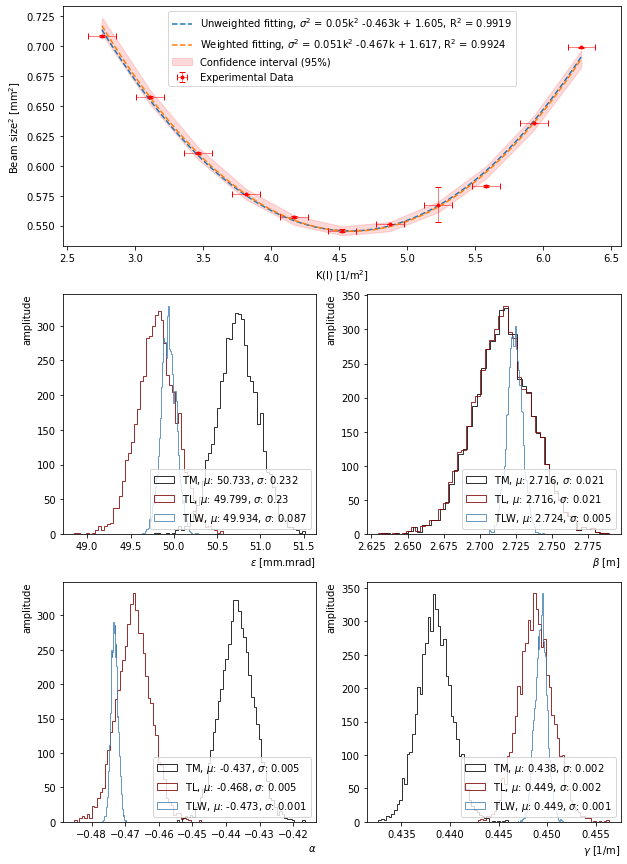

In [13]:
nemit_t, nemit_tl, nemit_tlw = emit_montec(energy, sigma, err_sigma, current, err_current, 'x', 5000, plot = True)

#### Compare the both methods differences in function of the number of random numbers

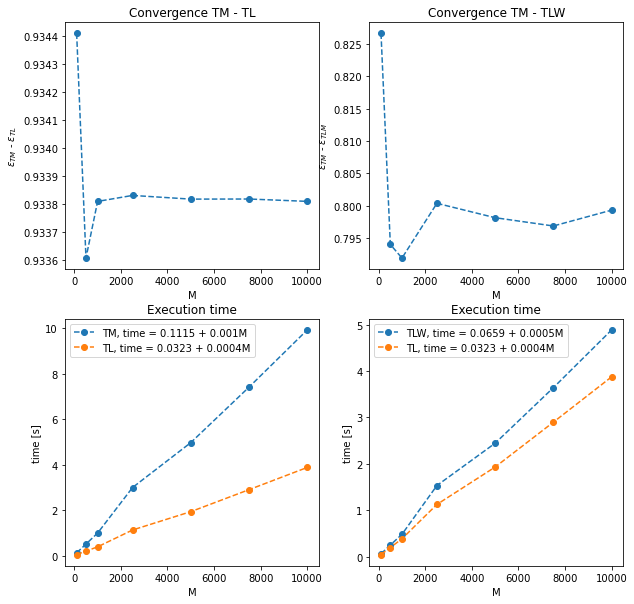

In [14]:
Ms = [100,500, 1000, 2500, 5000, 7500, 10000]
x0s = []
y0s = []
y0s2 = []
times_t = []
times_tl = []
times_tlw = []
for k in Ms:
    nemit_t, nemit_tl, nemit_tlw, time_t, time_tl, time_tlw = emit_montec(energy, sigma,err_sigma, current, err_current, 'x', k, plot = False, times = True)
    y0s.append(np.abs(np.mean(nemit_t)- np.mean(nemit_tl)))
    y0s2.append(np.abs(np.mean(nemit_t)- np.mean(nemit_tlw)))
    times_t.append(time_t)
    times_tl.append(time_tl)
    times_tlw.append(time_tlw)
    
a1, b1 = np.polyfit(Ms,times_t,1)
a2, b2 = np.polyfit(Ms,times_tl,1)
a3, b3 = np.polyfit(Ms,times_tlw,1)
fig = plt.figure(figsize=(10,10))
gs = GridSpec(2,2) # 1 rows, 2 columns
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax1.plot(Ms, y0s, "o--")
ax1.set_xlabel('M')
ax2.set_xlabel('M')
ax1.set_ylabel('$\epsilon_{TM}$ - $\epsilon_{TL}$')
ax2.set_ylabel('$\epsilon_{TM}$ - $\epsilon_{TLM}$')
ax2.plot(Ms, y0s2, "o--")
ax3.plot(Ms,times_t , "o--", label= 'TM, time = '+ str(round(b1, 4))+ ' + '+str(round(a1, 4))+'M')
ax3.plot(Ms,times_tl , "o--", label= 'TL, time = '+ str(round(b2, 4))+ ' + '+str(round(a2, 4))+'M')
ax4.plot(Ms,times_tlw , "o--", label= 'TLW, time = '+ str(round(b3, 4))+ ' + '+str(round(a3, 4))+'M')
ax4.plot(Ms,times_tl , "o--", label= 'TL, time = '+ str(round(b2, 4))+ ' + '+str(round(a2, 4))+'M')
ax3.set_xlabel('M')
ax4.set_xlabel('M')
ax3.set_ylabel('time [s]')
ax4.set_ylabel('time [s]')
ax1.set_title('Convergence TM - TL')
ax2.set_title('Convergence TM - TLW')
ax3.set_title('Execution time')
ax4.set_title('Execution time')
ax3.legend()
ax4.legend()
plt.show()